In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import bayes_net_utils as bn

%matplotlib inline

# Introduction

The aim of this notebook is to:

1) Generate a clean daily data matrix including potential features of use in predicting lake chemistry and ecology in Lake Vansjø. Data is read in for the River Hobøl and Lake Vansjø in the Morsa vannområde. Data includes meteorological data, NVE discharge data, river chemistry data and lake chemistry and ecology data for the period ca. 1980-2018. Data is cleaned and aligned.

2) Resample to seasonal, and calculate associated seasonally-aggregated potential explanatory features (e.g. lags, winter sums)

# User input

In [2]:
# User input
basin = 'Van2'  # Only option here is Van2

# Include TP flux estimates in the data matrix?
inc_fluxes = 0  # 0 or 1

# FILE PATHS to input data

# Met (T, pptn, wind)
met_source = 'metno'  # Originally, this could be other things. This is the only option here though
met_fpath = r'../Data/raw_input_data/Meteorological/metno/Obs_Metno_1km_gridded_Morsa_v2.csv'
wind_fpath = r'../Data/raw_input_data/Meteorological/metno/Obs_Rygge_MeanWindSpeed.csv' # Mean daily wind speed (m/s), Rygge airport

# Discharge
Q_fpath = r'../Data/raw_input_data/Discharge/3-22-0_D6pm_Hogfoss_Scaled_to_Kure.csv'

# Catchment water quality (at Kure)
catchwq_fpath = r'../Data/raw_input_data/Observed_Chem_Ecol/003-59191_Hobølelva_Kure_chem_obs.csv'

# Lake water quality
lakewq_fpath = r'../Data/raw_input_data/Observed_Chem_Ecol/Van2_Vanemfjorden_chem_obs.csv'

# Alternative lake colour data (from Storefjorden, 20m depth, MOVAR data)
movar_color_fpath = r'../Data/raw_input_data/Observed_Chem_Ecol/LakeColour_MOVAR.csv'

# Lake ecology (cyano biovolume)
ecol_fpath = r'../Data/raw_input_data/Observed_Chem_Ecol/Van2_Vanemfjorden_Cyanobacteria.csv'

# Output folders
out_folder = r'../Data/DataMatrices'
graph_outfolder = r'../Figures/Timeseries_daily'

# Daily data

## Read in daily data

In [3]:
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=True)
wind_df = pd.read_csv(wind_fpath, index_col=0, parse_dates=True, dayfirst=True)
Q_df = pd.read_csv(Q_fpath, index_col=0, parse_dates=True, dayfirst=True)
catchwq_df = pd.read_csv(catchwq_fpath, index_col=0, parse_dates=True, dayfirst=True)
lakewq_df = pd.read_csv(lakewq_fpath, index_col=0, parse_dates=True, dayfirst=True)
color_df = pd.read_csv(movar_color_fpath, index_col=0, parse_dates=True, dayfirst=True)

# Read in ecol data from excel sheet one sheet at a time, then merge
ecol_df = pd.read_csv(ecol_fpath, index_col=0, parse_dates=True, dayfirst=True)
# convert units to mm3/l (mg/l if assume density is same as water)
ecol_df['Cyano_biovol_mm3_per_l'] = ecol_df['Cyano_biovol_mm3_per_m3']/1000.
ecol_df.drop(['Cyano_biovol_mm3_per_m3'], axis=1, inplace=True)

## Data cleaning and reorganising

### Meteorology and discharge

In [4]:
# MET DATA

# For the met data, just pick the columns of interest and rename them
met_df = met_df[["RR_catch", "TG_catch"]]
# For now, pick rainfall and temp averaged over whole catchment, not just the lake
met_df.columns = ["Pptn", "Temp"]
met_df.index.name = "Date"
met_df.index = met_df.index.normalize()  # Drop time info from metdf index
# Add mean daily wind speed (m/s)
met_df["Wind_speed"] = wind_df.iloc[:, 0]

# Remove some dodgy-looking values
met_df.loc[met_df["Pptn"] < 0.0, "Pptn"] = 0.0

met_df.head()

,Pptn,Temp,Wind_speed
Date,,,
1970-12-31,0.000000,-9.243695,4.6
1971-01-01,0.000000,-10.881015,0.2
1971-01-02,0.000000,-9.843024,0.3
1971-01-03,0.000000,-2.851721,6.0
1971-01-04,0.000096,-2.219738,2.2


In [5]:
# Q DATA
Q_df = Q_df['Q_18H_average_m3s_scaled']
Q_df.rename('Q', inplace=True)

Date
1976-09-23    0.089
1976-09-24    0.089
1976-09-25    0.089
1976-09-26    0.090
1976-09-27    0.088
              ...  
2018-09-25    0.392
2018-09-26    0.360
2018-09-27    0.399
2018-09-28    0.424
2018-09-29    0.370
Name: Q, Length: 11702, dtype: float64

### Process lake colour data

In [6]:
# Lake colour data (merge MOVAR and NIVA data). Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
lakewq_df = pd.merge(lakewq_df, color_df, left_index=True,
                     right_index=True, how='outer')

# Before Jan 1999: NIVA data, Jan 1999- end 2012: Movar data, from Jan 2013: NIVA data
s0 = lakewq_df.loc[:'1998-12-31', 'colour']

id1 = lakewq_df['Colour'].first_valid_index()
s1 = lakewq_df['Colour'].loc[id1:]
s1.name = 'colour'

lastidx = lakewq_df.loc['2013-01-01':, 'colour'].last_valid_index()
s2 = lakewq_df.loc['2013-01-01':lastidx, 'colour']

colour = pd.concat([s0, s1, s2], axis=0).dropna()

# Drop original MOVAR and NIVA colour series, and replace with the patched series
lakewq_df = lakewq_df.drop(['colour', 'Colour'], axis=1)
lakewq_df = lakewq_df.merge(colour.to_frame(), left_index=True,
                            right_index=True, how='outer')

# Drop some dodgy-looking values
lakewq_df.loc[:'1982-08-01', 'colour'] = np.NaN
# lakewq_df[lakewq_df[['SS','SS_min']]>25.] = np.NaN

### Combine data

Combine into one dataframe, and drop unwanted rows and columns

                Pptn       Temp  Wind_speed       Q  TP_catch  chl-a_lake  \
Date                                                                        
1980-01-01  0.000000  -4.758278         2.9   4.252       NaN         NaN   
1980-01-02  0.000000  -8.821736         3.1   5.544       NaN         NaN   
1980-01-03  0.000000 -15.280719         1.5   8.203       NaN         NaN   
1980-01-04  2.669136 -12.965066         1.7  10.461       NaN         NaN   
1980-01-05  2.806878  -5.304253         1.5  10.239       NaN         NaN   

            TP_lake  colour_lake  CyanoBiovol  
Date                                           
1980-01-01      NaN          NaN          NaN  
1980-01-02      NaN          NaN          NaN  
1980-01-03      NaN          NaN          NaN  
1980-01-04      NaN          NaN          NaN  
1980-01-05      NaN          NaN          NaN  


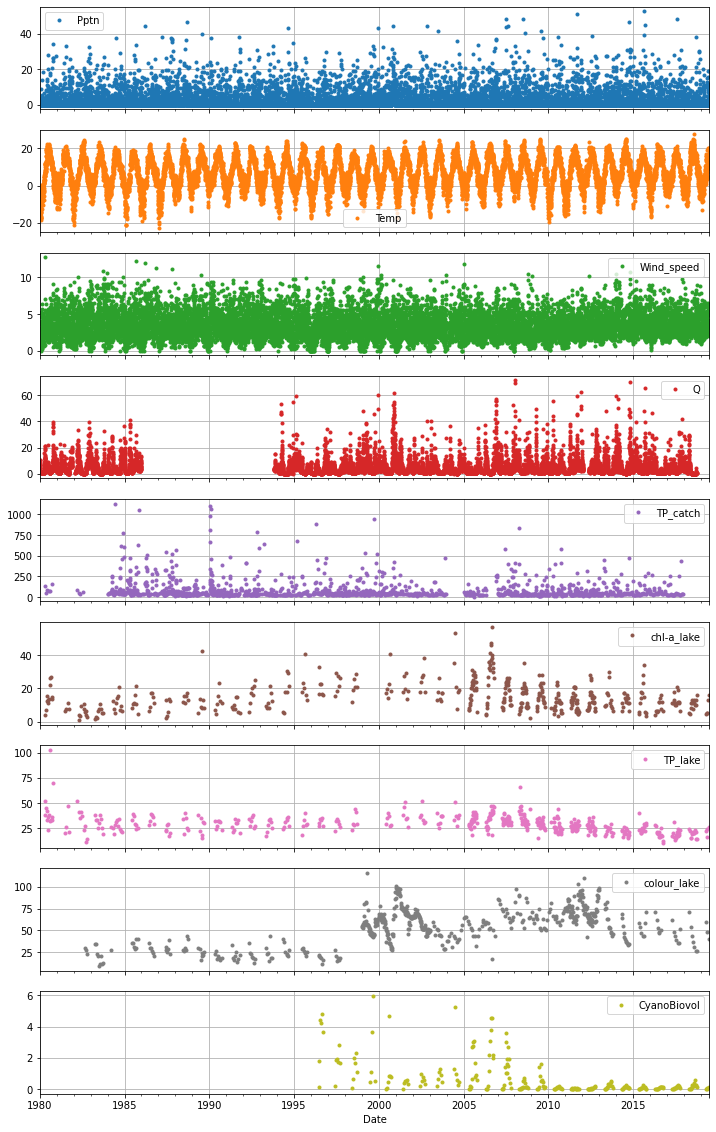

In [7]:
# Add suffixes to lake and water quality columns
catchwq_df = catchwq_df.add_suffix("_catch")
lakewq_df = lakewq_df.add_suffix("_lake")

# REINDEX & JOIN ALL DATASETS INTO ONE DATAFRAME
df_list = [met_df, Q_df, catchwq_df, lakewq_df, ecol_df]

for i, df in enumerate(df_list):
    df = df.reindex(index=met_df.index)
    if i < 1:
        daily_df = df
    else:
        daily_df = daily_df.join(df)

# Remove data pre-1980
daily_df = daily_df.loc["1980-01-01":, :]

# Drop some cols and rename others
cols_to_drop = ["SS_min_catch", "SS_catch", "TDP_catch", "SRP_catch"]

var_rename_dict = {
    "Biovolume_mm3_per_l": "Biovolume",
    "Cyano_biovol_mm3_per_l": "CyanoBiovol",
}

daily_df.drop(cols_to_drop, axis=1, inplace=True)
daily_df.rename(var_rename_dict, axis=1, inplace=True)

# Check output
print(daily_df.head())
daily_fig = daily_df.loc["1980-01-01":, :].plot(
    subplots=True, style="o", ms=3, figsize=(12, 20), grid=True
)

# plt.savefig(os.path.join(graph_outfolder,'daily_data_tseries_%s.png' %met_source))

### Add precipitation-related features

Add derived variables from daily data.Possible precipitation features, using definitions from the Australian Met service:
1) rain day (boolean of whether it rained that day or not), defined as annual count of days with daily precipitation ≥ 1 mm (to filter out small errors in values under 1 mm).
2) Heavy precipitation days: Annual count of days with daily precipitation ≥ 10 mm

                Pptn  Rain_day
Date                          
1980-01-01  0.000000         0
1980-01-02  0.000000         0
1980-01-03  0.000000         0
1980-01-04  2.669136         1
1980-01-05  2.806878         1
8.499137083600006
                Pptn  Pptn_intense
Date                              
1980-01-01  0.000000             0
1980-01-02  0.000000             0
1980-01-03  0.000000             0
1980-01-04  2.669136             0
1980-01-05  2.806878             0


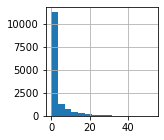

In [8]:
# 1) Rain days
def rain_day(pptn):
    if pptn > 1:
        return 1
    else:
        return 0


daily_df["Rain_day"] = daily_df["Pptn"].map(rain_day)
print(daily_df[["Pptn", "Rain_day"]].head())

# 2) Intense rain days: Boolean saying whether precipitation is above a certain threshold
# First, take a look at the distribution of rainfall to decide on the threshold
daily_df["Pptn"].hist(bins=15, figsize=(2, 2))
print(daily_df["Pptn"].quantile(q=0.90))


# Decide to go again with AU definition of 'Heavy precipitation days'
def rain_intense(pptn):
    if pptn > 10.0:
        return 1
    else:
        return 0


daily_df["Pptn_intense"] = daily_df["Pptn"].map(rain_intense)
print(daily_df[["Pptn", "Pptn_intense"]].head())

### Add wind speed-related features

The main thing that is likely to be important for cyanobacteria is a stable upper water column, so that turbulence doesn't cause cells to sink. The duration of the stable upper water column could also be important, so features could be e.g. x days below whatever wind speed threshold is required for a stable upper water column, AND no (potentially short-lived) periods where the water column is mixed due to high winds.

Q0.2: 2.0 m/s
Q0.4: 2.9 m/s


Q0.6: 3.8 m/s
Q0.8: 4.8 m/s
            Wind_speed  Wind_under_Q0.2  Wind_over_Q0.6
Date                                                   
1980-01-01         2.9            False           False
1980-01-02         3.1            False           False
1980-01-03         1.5             True           False
1980-01-04         1.7             True           False
1980-01-05         1.5             True           False


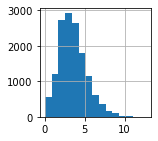

In [9]:
# Wind features: Boolean saying whether wind speed was above or below a certain threshold

# Distribution of wind speed
daily_df["Wind_speed"].hist(bins=15, figsize=(2, 2))

# Define 'calm day' features
calm_quantiles = [0.2, 0.4]
for quantile in calm_quantiles:
    upper_threshold = daily_df["Wind_speed"].quantile(quantile)
    print("Q%s: %s m/s" % (quantile, upper_threshold))
    daily_df["Wind_under_Q%s" % quantile] = daily_df["Wind_speed"] < upper_threshold

print("\n")

# Define 'windy day' features
windy_quantiles = [0.6, 0.8]
for quantile in windy_quantiles:
    lower_threshold = daily_df["Wind_speed"].quantile(quantile)
    print("Q%s: %s m/s" % (quantile, lower_threshold))
    daily_df["Wind_over_Q%s" % quantile] = daily_df["Wind_speed"] > lower_threshold

print(daily_df[["Wind_speed", "Wind_under_Q0.2", "Wind_over_Q0.6"]].head())

### Add temperature-related features

Calculate winter freezing days (days where T<0), and assume the more subzero days the thicker the ice and the longer the ice duration.

In [10]:
daily_df["Temp_subzero"] = daily_df["Temp"] < 0.0
daily_df[["Temp", "Temp_subzero"]].head()

,Temp,Temp_subzero
Date,,
1980-01-01,-4.758278,True
1980-01-02,-8.821736,True
1980-01-03,-15.280719,True
1980-01-04,-12.965066,True
1980-01-05,-5.304253,True


## Output daily data matrix

In [11]:
# Output to csv
daily_df.to_csv(
    os.path.join(out_folder, "Daily/", "Vansjø_daily_data_%s_%s.csv" % (basin, met_source)),
    index_label="Date",
)

# Resample to seasonal

In [12]:
# Set the aggregation method for different variables

vars_to_sum = ["Pptn", "Rain_day", "Pptn_intense", "Q", "Temp_subzero"]

# Add wind cols to vars to sum
wind_cols = []
for q in calm_quantiles:
    wind_cols.append("Wind_under_Q%s" % q)
for q in windy_quantiles:
    wind_cols.append("Wind_over_Q%s" % q)
vars_to_sum += wind_cols

vars_to_average = [
    "TP_catch",
    "PTI",
    "Temp",
    "Biovolume",
    "rel_res_time",
    "colour_lake",
    "TP_lake",
    "chl-a_lake",
    "Wind_speed",
]

vars_to_max = ["CyanoBiovol"]

agg_method_dict = {}  # Key: var, returns aggregation method
for var in daily_df.columns:
    if var in vars_to_sum:
        method = np.nansum
    elif var in vars_to_average:
        method = np.nanmean
    elif var in vars_to_max:
        method = np.nanmax
    else:
        method = None
    agg_method_dict[var] = method

# agg_method_dict

For the summer season, you might expect chl-a and cyanobacteria, which have peaks in June-Aug, to show stronger correlations with met variables during these three months, rather than during the full 6 month growing season period. I tried this out, using the code below to calculate just June-Aug seasonal sums/averages, replacing 'daily_df' with 'masked_daily_df' when calculating the seasonal summaries, and then running through the correlations and scatterplots with this different seasonal averaging. But it didn't make any difference, no stronger links between in-lake biol and met variables. Therefore go back to full season summary stats.

In [13]:
# # For summer sesason, met vars perhaps better summed/averaged over just June-Aug when looking
# # for links to algal stuff. Try that.

# # Vars to mask. Just met vars.
# peak_summer_vars = vars_to_sum.copy()
# peak_summer_vars.extend(['Temp','Wind_speed'])
# mask_months = [5,9,10] # Summer months to exclude in seasonal aggregation

# masked_daily_df = daily_df.copy()
# masked_daily_df.loc[masked_daily_df.index.month.isin(mask_months), peak_summer_vars] = np.NaN

# masked_daily_df.loc['1991-04-29':'1991-11-01',['Temp','Pptn']]

In [14]:
season_df = bn.daily_to_summer_season(daily_df,
                                      agg_method_dict=agg_method_dict,
                                      replace_zero_with_NaN_li=['Q'],
                                      return_just_summer=False)

# Particularly for summed variables, drop 1980 as missing first 2 months
for col in season_df.columns:
    if col in vars_to_sum:
        season_df[col].iloc[0] = (np.NaN)
        # NOTE: Assumes first year is 1980

# Also drop summer 2019, as have lots of missing data
season_df = season_df.drop([season_df.index[-1]])

# For Q, change the units (summed up m3/s over days, convert to 10^6 m3 per season)
season_df["Q"] = season_df["Q"] * (86400.0 / 10**6)

season_df

,Pptn,Temp,Wind_speed,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,Wind_over_Q0.8,Temp_subzero,Season
Date,,,,,,,,,,,,,,,,,
1980-04-30,NaN,-2.949842,2.856667,NaN,130.000000,3.971429,45.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wint
1980-10-31,579.570268,13.006020,3.324457,87.603466,86.400000,16.080130,43.573016,NaN,NaN,83.0,16.0,34,81,56,27,6,summ
1981-04-30,244.713839,-0.844447,3.432044,69.390950,NaN,NaN,NaN,NaN,NaN,39.0,5.0,40,67,65,38,95,wint
1981-10-31,494.520283,12.574081,3.479891,61.606742,NaN,8.331250,28.833333,NaN,NaN,61.0,17.0,30,69,67,35,0,summ
1982-04-30,371.084444,-1.856862,3.383978,96.553901,69.000000,1.100000,46.250000,NaN,NaN,61.0,10.0,47,81,70,42,92,wint
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-30,299.217857,1.935857,3.674033,61.375709,78.363636,11.000000,17.000000,62.000000,0.018,45.0,12.0,33,63,71,44,53,wint
2017-10-31,570.221295,13.359368,3.705435,68.075251,77.928571,12.866667,19.666667,42.000000,0.258,76.0,20.0,9,55,75,36,0,summ
2018-04-30,386.373363,0.168647,3.454144,105.737616,35.000000,5.500000,24.000000,71.000000,0.002,61.0,11.0,28,69,58,30,97,wint


# Add lagged variables

## Add 1 lag (i.e. subtract one 6-month season)

In [15]:
# Only do for variables that we will have data for or may be able to estimate
lag_vars = [
    "Pptn",
    "Temp",
    "Wind_speed",
    "Q",
    "Rain_day",
    "Pptn_intense",
    "Wind_under_Q0.2",
    "Wind_under_Q0.4",
    "Wind_over_Q0.6",
    "Wind_over_Q0.8",
]

for var in lag_vars:
    season_df["%s_lag1" % var] = season_df[var].shift(+1)

season_df[["Pptn", "Pptn_lag1"]].head()

,Pptn,Pptn_lag1
Date,,
1980-04-30,NaN,NaN
1980-10-31,579.570268,NaN
1981-04-30,244.713839,579.570268
1981-10-31,494.520283,244.713839
1982-04-30,371.084444,494.520283


## Add summer averages from the previous year

Calculate summer averages from previous year. Could define summer as the whole WFD growing season (May-Oct, incl.), or as just the key summer months (June-Aug/Sep). Explored both and find no difference to results, so use the whole WFD growing season.

For cyanobacteria, I explored using the maximum or the mean from the previous summer in all the exploratory stats. Found no difference to results, but decide to use mean as it is more robust than the maximum.

In [16]:
prev_summer_toaverage = ['TP_lake', 'colour_lake', 'chl-a_lake', 'Temp', 'CyanoBiovol']

# Filter to just summer and shift
prevSummerCols = season_df.loc[season_df['Season'] == 'summ',
                               prev_summer_toaverage].shift(+1)
prevSummerCols = prevSummerCols.add_suffix('_prevSummer')
prevSummerCols.head()

season_df = season_df.join(prevSummerCols)

In [17]:
# 'Previous summer' vars are all NaNs for winter season. Fill them backwards
season_df[prevSummerCols.columns] = season_df[prevSummerCols.columns].fillna(
    method="bfill", axis=0, limit=1
)

season_df.loc[
    "2016":"2018",
    ["TP_lake", "TP_lake_prevSummer", "Temp", "Temp_prevSummer"]
]

,TP_lake,TP_lake_prevSummer,Temp,Temp_prevSummer
Date,,,,
2016-04-30,28.000000,24.250000,1.761570,12.708488
2016-10-31,18.750000,24.250000,14.037478,12.708488
2017-04-30,17.000000,18.750000,1.935857,14.037478
2017-10-31,19.666667,18.750000,13.359368,14.037478
2018-04-30,24.000000,19.666667,0.168647,13.359368
2018-10-31,18.666667,19.666667,15.439945,13.359368


# Output seasonal data matrix with all data

In [18]:
season_df.to_csv(
    os.path.join(
        out_folder,
        "Seasonal_6monthly",
        "Vansjø_seasonal_data_1Season_%s_%s.csv" % (basin, met_source),
    )
)